In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(root='veggie_heap_training', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = CNN(num_classes=len(train_data.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_data)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

torch.save(model.state_dict(), 'trained_model.pth')





Epoch [1/5], Loss: 1.2547
Epoch [2/5], Loss: 0.5777
Epoch [3/5], Loss: 0.4150
Epoch [4/5], Loss: 0.3339
Epoch [5/5], Loss: 0.2822


Input Image (RGB)
    ↓
Conv2d (3 input channels, 64 output channels, kernel_size=3, padding=1)
    ↓
ReLU 
    ↓
MaxPool2d (kernel_size=2, stride=2)
    ↓
Conv2d (64 input channels, 128 output channels, kernel_size=3, padding=1)
    ↓
ReLU 
    ↓
MaxPool2d (kernel_size=2, stride=2)
    ↓
Flatten
    ↓
Linear (128*56*56 input features, 256 output features)
    ↓
ReLU 
    ↓
Linear (256 input features, num_classes output features)
    ↓
Output (Logits for each class)




Accuracy: 0.90


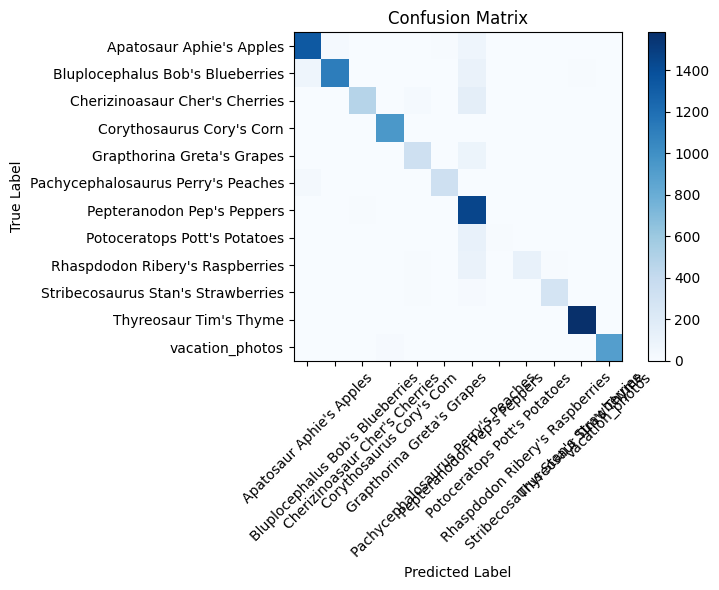

                                    precision    recall  f1-score   support

          Apatosaur Aphie's Apples       0.92      0.92      0.92      1445
  Bluplocephalus Bob's Blueberries       0.97      0.85      0.91      1302
    Cherizinoasaur Cher's Cherries       0.94      0.73      0.82       654
         Corythosaurus Cory's Corn       0.98      1.00      0.99       945
        Grapthorina Greta's Grapes       0.87      0.78      0.82       423
Pachycephalosaurus Perry's Peaches       0.95      0.90      0.92       360
        Pepteranodon Pep's Peppers       0.69      0.98      0.81      1478
      Potoceratops Pott's Potatoes       1.00      0.08      0.15       152
   Rhaspdodon Ribery's Raspberries       0.93      0.49      0.65       249
Stribecosaurus Stan's Strawberries       0.93      0.91      0.92       306
            Thyreosaur Tim's Thyme       0.99      1.00      0.99      1591
                   vacation_photos       0.99      0.97      0.98       930

          

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = train_data.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


Testing Accuracy: 0.61


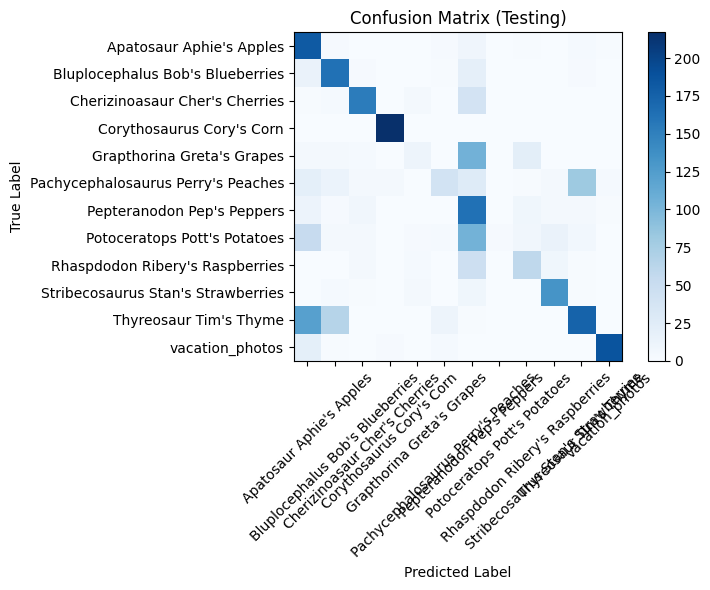

                                    precision    recall  f1-score   support

          Apatosaur Aphie's Apples       0.42      0.91      0.58       200
  Bluplocephalus Bob's Blueberries       0.63      0.81      0.71       200
    Cherizinoasaur Cher's Cherries       0.85      0.77      0.80       200
         Corythosaurus Cory's Corn       0.97      1.00      0.99       217
        Grapthorina Greta's Grapes       0.46      0.07      0.13       150
Pachycephalosaurus Perry's Peaches       0.67      0.20      0.31       199
        Pepteranodon Pep's Peppers       0.31      0.81      0.45       200
      Potoceratops Pott's Potatoes       1.00      0.01      0.02       200
   Rhaspdodon Ribery's Raspberries       0.60      0.48      0.54       122
Stribecosaurus Stan's Strawberries       0.81      0.89      0.85       150
            Thyreosaur Tim's Thyme       0.64      0.47      0.54       373
                   vacation_photos       0.97      0.88      0.92       213

          

In [7]:
test_data = ImageFolder(root='veggie_heap_testing', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


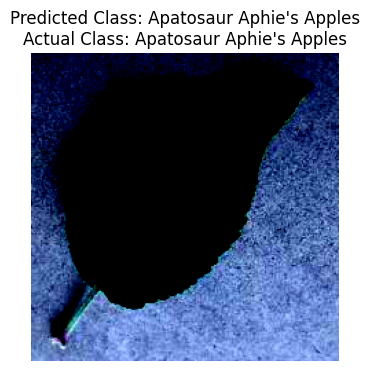

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


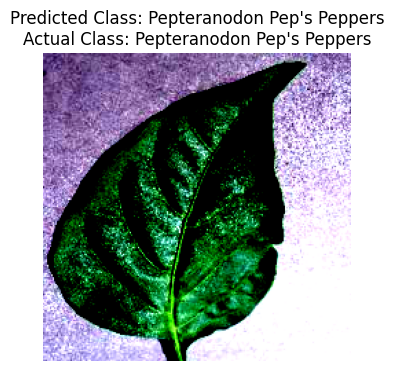

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


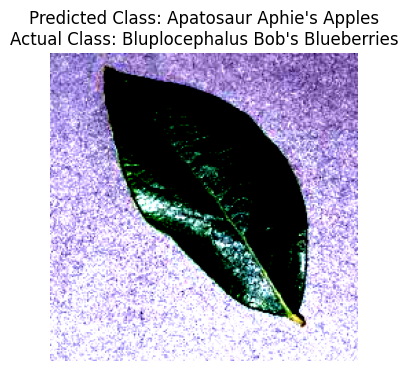

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


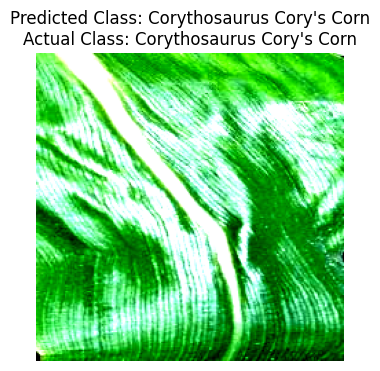

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


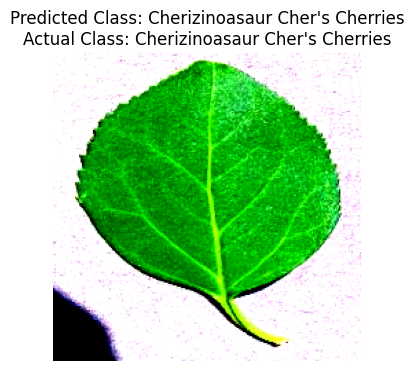

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


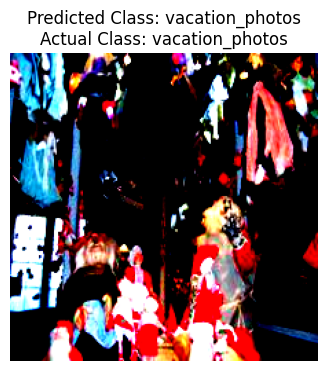

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


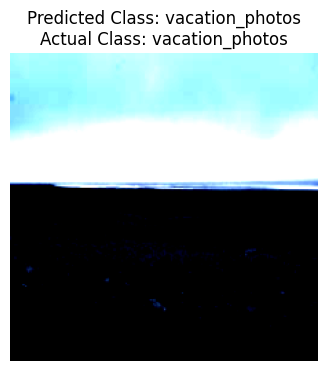

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


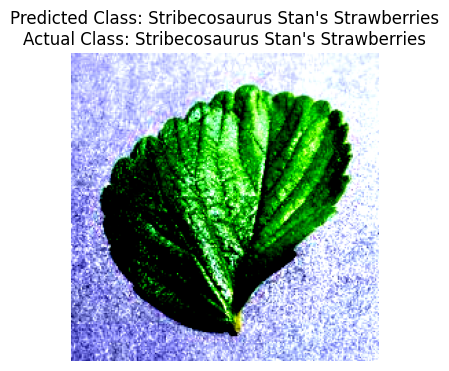

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


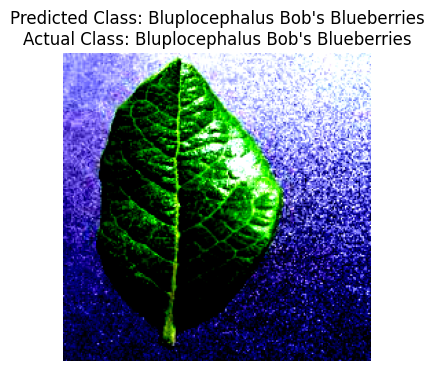

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


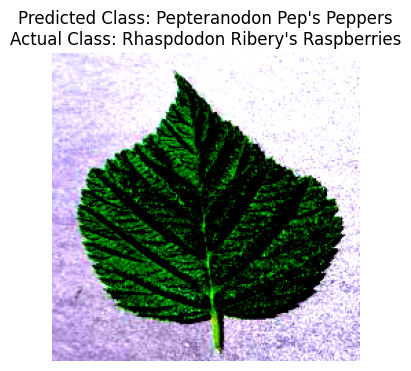

In [8]:
import random
from PIL import Image

def display_random_images(model, data_loader, class_names, num_images=10):
    model.eval()

    random_indices = random.sample(range(len(data_loader.dataset)), num_images)

    for idx in random_indices:
        image_path = data_loader.dataset.imgs[idx][0]
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)

        true_label = data_loader.dataset.targets[idx]
        true_class = class_names[true_label]

        with torch.no_grad():
            output = model(image)
            _, predicted_label = torch.max(output, 1)
            predicted_class = class_names[predicted_label.item()]

        plt.figure(figsize=(8, 4))
        plt.imshow(np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0)))
        plt.title(f"Predicted Class: {predicted_class}\nActual Class: {true_class}")
        plt.axis('off')
        plt.show()

display_random_images(model, train_loader, class_names, num_images=10)
